# Cutting-Edge project - Milliman


- Members: **Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
- Group 2
- Professional partner: **[Milliman](https://www.milliman.com/en/)**

*January 2023 - Present*

---

## Preliminaries

To execute this Jupyter Notebook on a local environment or on a Google Colab/Binder online system, please make sure you have all the prerequisites installed.

- If you are using **`pip`** for packaging management, please run:

In [1]:
#!pip install -r requirements.txt

- If you are using **`pip3`** for packaging management, please run:

In [2]:
!pip3 install -r requirements.txt


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


- If you are using **`conda`** (Anaconda) for packaging management, please run:

In [3]:
!conda install --yes --file requirements.txt

zsh:1: command not found: conda


---

The next cell imports all the required Python modules.

In [14]:
import numpy as np
import numpy.random as npr
import time
import warnings
import scipy
import random
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import missingno as msn
import QuantLib as ql

# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
npr.seed(1)

In [15]:
# Global variables & constants
_MAX_STEPS = int(1e5)

# Defining the available numerical schemes
Scheme = Enum('Scheme', ["EULER", "MILSTEIN"])

In [23]:
class Model:
    """ Abstract class for models """
    pass

In [17]:
# Function to explicitly cast a dictionary or Numpy array into a pandas DataFrame
cast_df = lambda x: pd.DataFrame(x)

## Interest rates modelling

In [24]:
class RatesModel(Model):
    """ Abstract class for Interest rates models """
    pass

### Vasicek

In [77]:
class VasicekModel(RatesModel):
    """ Class representing the Vasicek model """
    
    MODEL_NAME = "VASICEK"
    
    def __init__(self, r0: float, kappa: float, theta: float, eta: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and eta > 0
        
        # Storing variable
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.eta = eta
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"Vasicek model {model.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"Vasicek model {model.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\eta$ = {self.eta})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, eta = {self.eta})"

    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
            
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        #dW = np.random.normal(0, 1, N)
        #plt.plot(dW)
        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.eta*dW[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Vasicek model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) = 0, the Milstein scheme is equivalent to the Euler scheme
        return self.simulate_euler(T, N)

In [32]:
# Default Vasicek model
model = VasicekModel(0.01875, 0.20, 0.01, 0.012)

In [33]:
# Displaying information on Vasicek model
model

Vasicek model (r0 = 0.01875, kappa = 0.2, theta = 0.01, eta = 0.012))

In [34]:
# Casting the results into a pandas DataFrame
df = cast_df(model.simulate_euler(T=3))

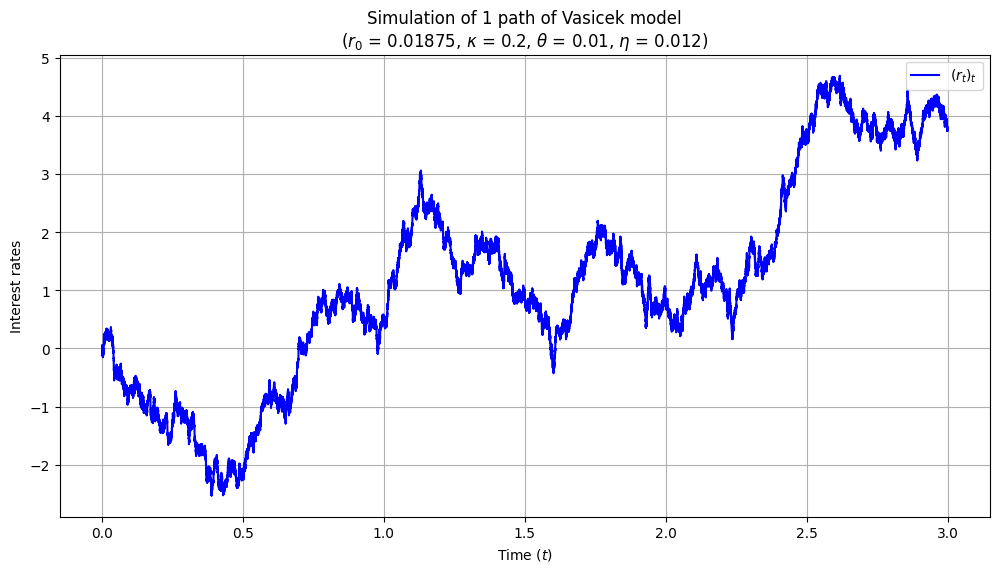

In [35]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

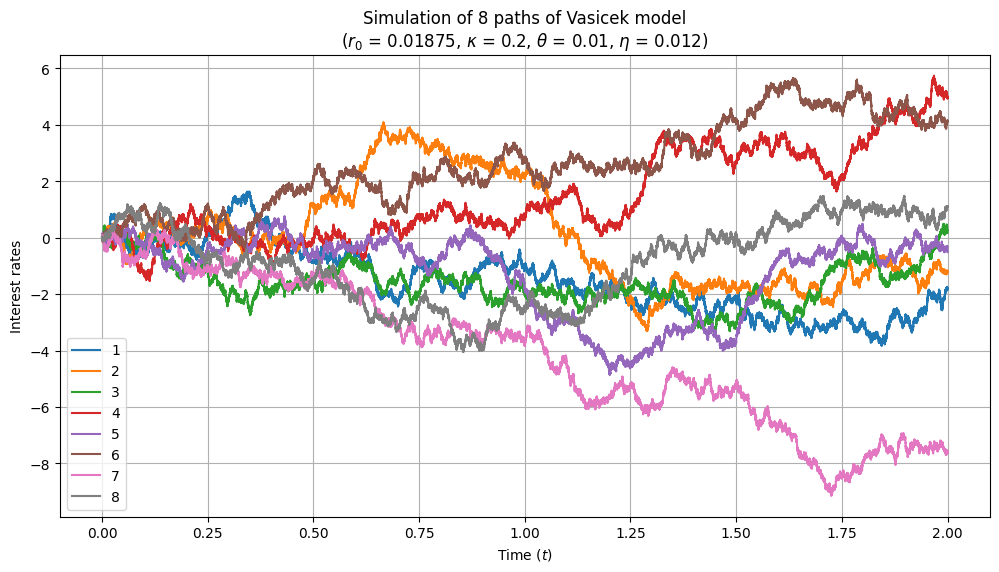

In [36]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = cast_df(model.simulate_paths(NB_TRAJECTORIES, T = 2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of Vasicek model\n{model.get_parameter_string()}")
_ = plt.legend()

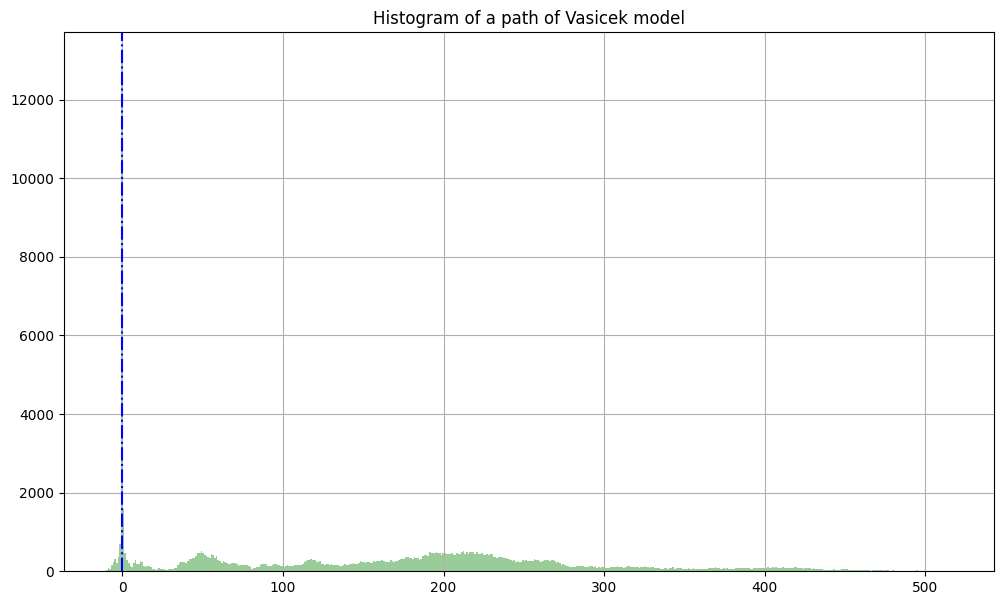

In [61]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), figsize=(12, 7), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

In [47]:
# Normality test (Shapiro-Wilk + Jarque-Bera)
TEST_THRESHOLD_ALPHA = 5e-2 # Threshold for p-value

# Definition of normality tests (Shapiro-Wilf + Jarque-Bera)
normtest_shapiro = lambda x: scipy.stats.shapiro(x).pvalue > TEST_THRESHOLD_ALPHA 
normtest_jarquebera = lambda x:scipy.stats.jarque_bera(x).pvalue > TEST_THRESHOLD_ALPHA

### Cox-Ingersoll-Ross (CIR)

In [78]:
class CIRModel(RatesModel):
    """ Class representing the Cox-Ingersoll-Ross (CIR) model """
    
    MODEL_NAME = "CIR"
    
    def __init__(self, r0: float, kappa: float, theta: float, sigma: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification
        assert r0 > 0 and kappa > 0 and theta > 0 and sigma > 0
        
        # Verifying the Feller condition
        self.feller_condition = 2*kappa*theta >= sigma**2
        if self.feller_condition:
            print("(r_t)_t strictly positive")
        
        # Storing variables
        self.r0 = r0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"CIR model {model.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"CIR model {model.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $\kappa$ = {self.kappa}, $\\theta$ = {self.theta}, $\sigma$ = {self.sigma})"
        return f"(r0 = {self.r0}, kappa = {self.kappa}, theta = {self.theta}, sigma = {self.sigma})"
    
    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_milstein(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
    
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following CIR model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            #if r[t] <= 0:
            #    r[t] = np.abs(r[t])
            r[t + 1] = r[t] + self.kappa*(self.theta - r[t])*dT + self.sigma*np.sqrt(np.abs(r[t]))*dW[t]
        return {"t": H, "r":r}
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following CIR model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) <> 0, the Milstein scheme is not equivalent to the Euler scheme
        # and a complete implementation is required !
        
        # Time step
        dT = T/float(N)

        # Generating the time horizon array
        H = np.arange(0, T, dT)

        # Generating the dW array
        dW = np.random.normal(0, 1, N)

        # Initializing the rates array
        r = np.zeros(N)
        r[0] = self.r0

        # Computing the rates
        for t in range(N - 1):
            #print(r[t])
            r[t + 1] = r[t] \
                     + self.kappa*(self.theta - r[t])*dT  \
                     + self.sigma*np.sqrt(np.abs(r[t]))*dW[t] \
                     + (1/2)*(dW[t]**2 - dT)*(self.sigma*np.sqrt(np.abs(r[t])))*(self.sigma)/(2*np.sqrt(np.abs(r[t])))
        return {"t": H, "r":r}
        
    def plot_feller_line(self, **kwards) -> None:
        """
        Function printing the Feller line to highlight the positivity of simulated rates
        """
        if self.feller_condition:
            plt.axhline(y=0, color="m", ls="-.", alpha=0.7, **kwards, label="Feller line")
            _ = plt.legend()
    

In [49]:
# Default CIR model
model = CIRModel(0.4, 0.20, 0.01, 0.12)

In [50]:
# Displaying information on Vasicek model
model

CIR model (r0 = 0.4, kappa = 0.2, theta = 0.01, sigma = 0.12))

In [57]:
# Casting the results into a pandas DataFrame
df = cast_df(model.simulate_euler(T=3))

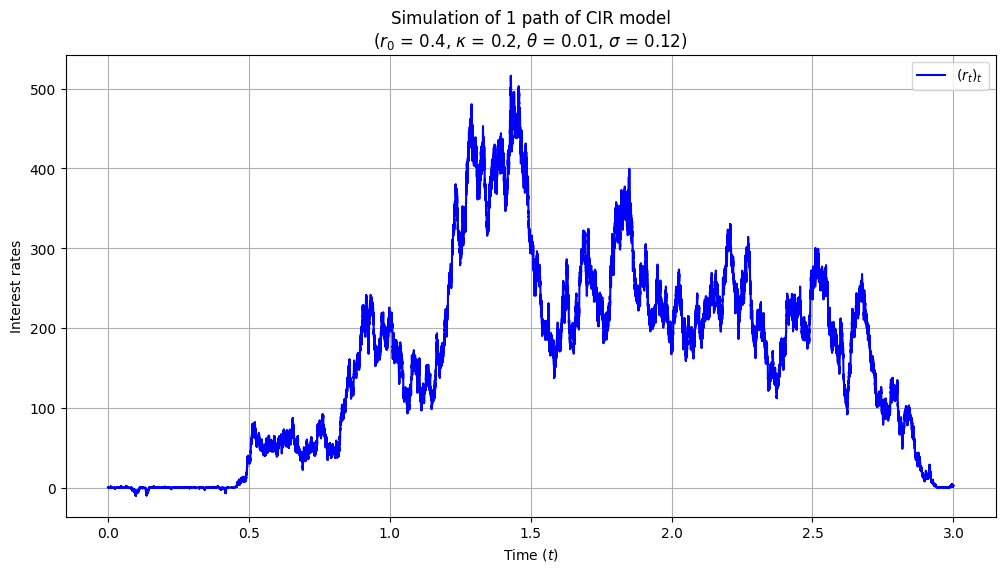

In [58]:
# Simulation of a trajectory
_ = df.plot(figsize=(12, 6), color="blue", x="t", y ="r", label="$(r_t)_t$")
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of 1 path of CIR model\n{model.get_parameter_string()}")
model.plot_feller_line()

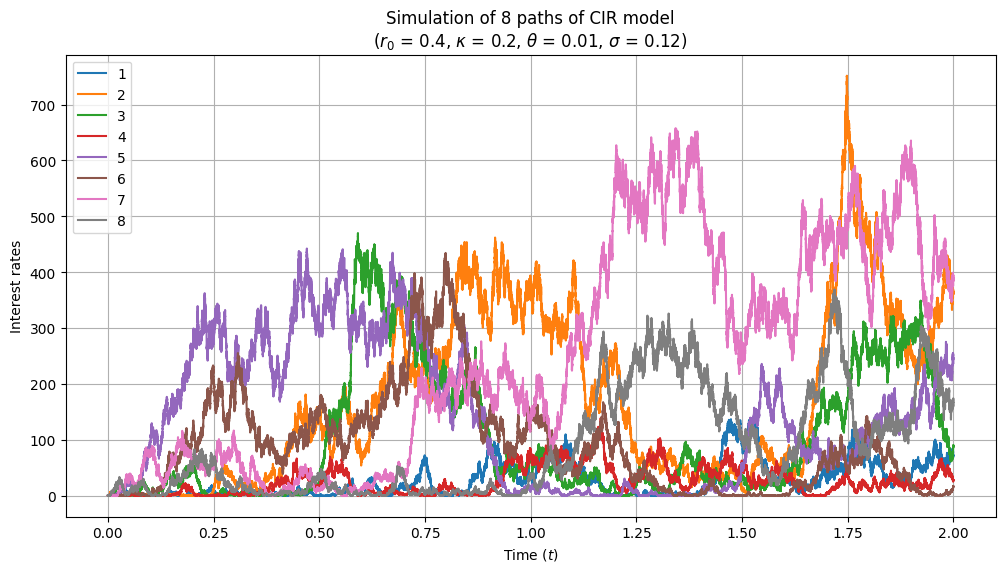

In [60]:
# Simulation of several trajectories
NB_TRAJECTORIES = 8
_ = cast_df(model.simulate_paths(NB_TRAJECTORIES, scheme=Scheme.MILSTEIN, T=2)).T.plot(x = 0, y = list(range(1, NB_TRAJECTORIES + 1)), figsize=(12, 6))
_ = plt.grid()
_ = plt.xlabel("Time ($t$)")
_ = plt.ylabel("Interest rates")
_ = plt.title(f"Simulation of {NB_TRAJECTORIES} paths of CIR model\n{model.get_parameter_string()}")
_ = plt.legend()

**Remark**: Strange behavior of the simulated curves because of the $\sqrt{\bullet}$ with negative rates when Feller condition is not satisfied.
- To be studied (one alternative is to add $\sqrt{|\bullet|}$ to handle negative rates (created by floating point operations)

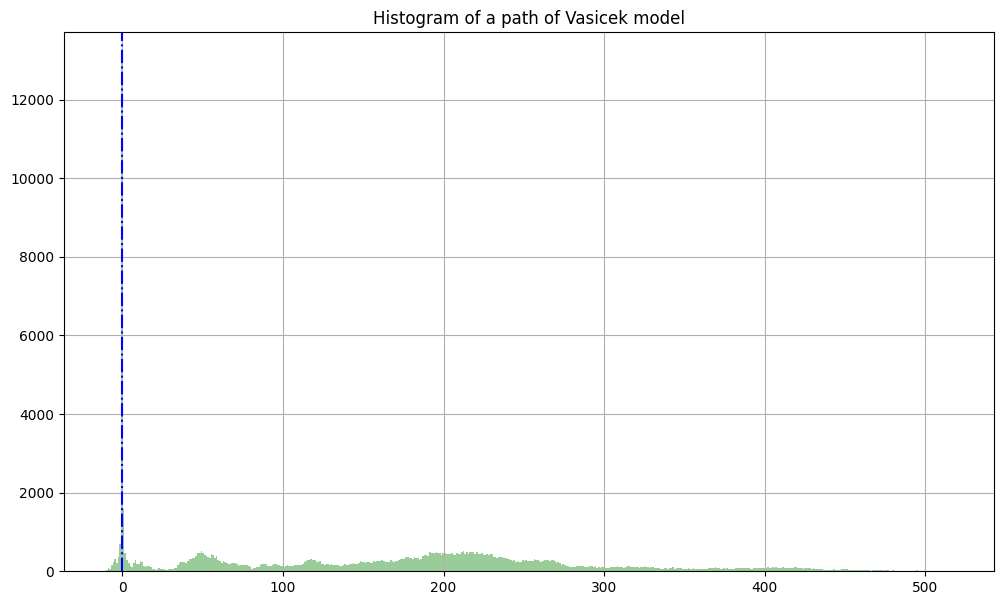

In [62]:
# Histogram of a path
_ = df["r"].hist(bins=int(5e2), figsize=(12, 7), color="green", alpha=0.4)
_ = plt.title("Histogram of a path of Vasicek model")
_ = plt.axvline(x = 0, ls = "-.", color="blue")

### Hull & White (HW) $\diamond$ Extended Vasicek

In [75]:
class HullWhiteModel(RatesModel):
    """ Class representing the Hull & White model """
    
    MODEL_NAME = "HULL-WHITE"
    
    def __init__(self, r0: float, a: float, sigma: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        
        Arguments:
        ---------
        r0: float
            Initial condition
        
        a: float
            Mean-reversion factor
        
        sigma: float
            Volatility factor
        """
        # Verification
        assert r0 > 0 and a > 0 and sigma > 0
        
        # Storing variables
        self.r0 = r0
        self.a = a
        self.sigma = sigma
    
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"Hull & White model {model.get_parameter_string(onLaTeX=False)})"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"Hull & White model {model.get_parameter_string(onLaTeX=False)}"
    
    def compute_theta(self) -> np.ndarray:
        """
        Function computing, storing and returning the theta 
        corresponding to the fitted interest rates term structure
        """
        # TODO
        pass
    
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($r_0$ = {self.r0}, $a$ = {self.a}, $\sigma$ = {self.sigma})"
        return f"(r0 = {self.r0}, a = {self.a}, sigma = {self.sigma})"
    
    # TODO: Add Euler !
    
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Hull & White model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated rates columns
        """
        # Since b'(.) = 0, the Milstein scheme is equivalent to the Euler scheme
        return self.simulate_euler(T, N)
    
    

**Protocol**: Gathering the input term structure of interest rates in order to construct the $\theta : \left[0, T\right] \longrightarrow \mathbb{R}$ deterministic functional.

In [904]:
# Setting up a random evaluation Date
today_date = ql.Date(31,1,2013)
ql.Settings.instance().setEvaluationDate(today_date)

# Setting up the yield termstructure
forward_rate = 0.04875825 #5e-3
rate = ql.SimpleQuote(forward_rate)
rate_handle = ql.QuoteHandle(rate)

# Setting up the day count convention to Actual/365
day_count = ql.Actual365Fixed() 
# day_count = ql.Thirty360(ql.Thirty360.BondBasis)

# Creating the discount curve with its own handler
discount_curve = ql.FlatForward(today_date, rate_handle, day_count)
discount_curve.enableExtrapolation()

# Creating the handler
handler_YTS = ql.YieldTermStructureHandle(disc_curve)

The `yieldTermStructure` object provides an method which gives us the discount factor for a particular date (`QuantLib.Date` object) or time in years (with 0 = `evaluationDate`). This method is called `discount()`.  

We are using the **numpy** method `vectorize` to apply this function on arrays or list of times and then generate a plot of the discount curve.

**Reference**: 
1. https://ipythonquant.wordpress.com/2015/04/04/a-brief-introduction-to-the-quantlib-in-python/

In [905]:
discount = np.vectorize(handler_YTS.discount)
time_horizon = np.arange(0, 10, 1/12)

In [906]:
d = discount(time_horizon)
d

array([1.        , 0.99750312, 0.99501248, 0.99252805, 0.99004983,
       0.9875778 , 0.98511194, 0.98265224, 0.98019867, 0.97775124,
       0.97530991, 0.97287468, 0.97044553, 0.96802245, 0.96560542,
       0.96319442, 0.96078944, 0.95839047, 0.95599748, 0.95361047,
       0.95122942, 0.94885432, 0.94648515, 0.94412189, 0.94176453,
       0.93941306, 0.93706746, 0.93472772, 0.93239382, 0.93006575,
       0.92774349, 0.92542702, 0.92311635, 0.92081144, 0.91851228,
       0.91621887, 0.91393119, 0.91164921, 0.90937293, 0.90710234,
       0.90483742, 0.90257815, 0.90032452, 0.89807652, 0.89583414,
       0.89359735, 0.89136614, 0.88914051, 0.88692044, 0.8847059 ,
       0.8824969 , 0.88029342, 0.87809543, 0.87590293, 0.87371591,
       0.87153435, 0.86935824, 0.86718755, 0.86502229, 0.86286244,
       0.86070798, 0.85855889, 0.85641518, 0.85427681, 0.85214379,
       0.85001609, 0.8478937 , 0.84577662, 0.84366482, 0.84155829,
       0.83945702, 0.837361  , 0.83527021, 0.83318464, 0.83110

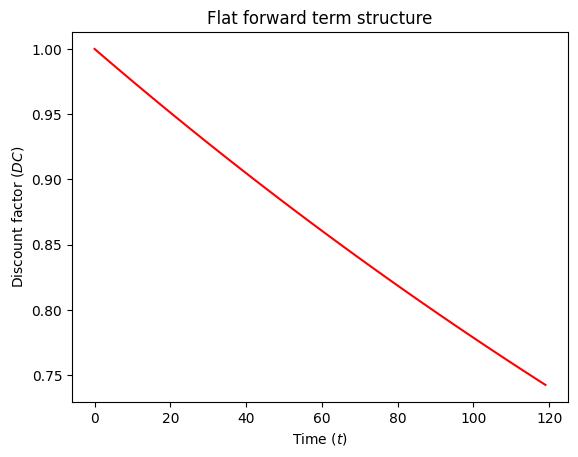

In [907]:
_ = pd.Series(d).plot(color="red")
_ = plt.title("Flat forward term structure")
_, _ = plt.xlabel("Time ($t$)"), plt.ylabel("Discount factor ($DC$)")

### Black–Karasinski

In [937]:
# TODO

### Ho-Lee

In [67]:
# TODO

## Equity modelling

In [68]:
class EquityModel(Model):
    """ Abstract class for Equity-Index models """
    pass

<span style="color:black"><b>Remark</b>: We have to take into account the parameter $\rho \in \left[-1, 1\right]$ as the correlation between the two Brownian motions.</span>

In [83]:
def generate_correlated_gaussians(rho: float = 0.5,
                                  T: float = 1.0,
                                  N: int = _MAX_STEPS) -> np.ndarray:
    """
    Function which generates a series of two Gaussian series correlated by the given
    factor $\rho$
    """
    # Checking the value of rho
    assert rho < 1.0 and rho > -1.0
    
    # Creating the correlation matrix
    C = np.array([[1, rho], [rho, 1]])
    
    # Performing the Cholesky decomposition
    L = np.linalg.cholesky(C) # L is the lower triangular matrix, L.T is the upper triangular matrix
    
    # Setting up the time step
    dT = T/N
    
    # Creation of 2 Brownian motions with N steps
    X = np.random.normal(0, (dT**(1/2)), (2, N))
    
    # Compute the correlated paths
    CX = np.dot(L, X)
    
    # Checking the correlation ratio of the simulated BM
    corr_coeff = np.corrcoef(CX.cumsum(axis=1))[1][0]
    print("-------------- Generation of Brownian Motions --------------")
    print(f"Simulated rho: {corr_coeff} \tGiven rho: {rho}\nAbsolute error: {np.abs(corr_coeff - rho)}")
    
    # Return the correlated paths
    return CX

In [84]:
def generate_correlated_brownians(*args, **kwargs) -> np.ndarray:
    """
    Function which generates a series of two Brownian motions correlated by the given
    factor $\rho$
    """
    CX = generate_correlated_gaussians(*args, **kwargs)
    return [path.cumsum() for path in CX]

-------------- Generation of Brownian Motions --------------
Simulated rho: 0.9989340066380042 	Given rho: 0.99
Absolute error: 0.008934006638004255


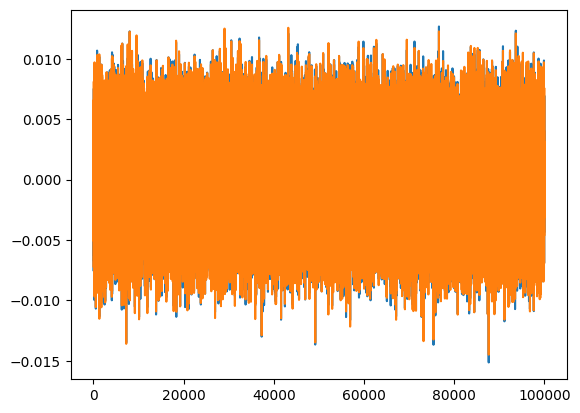

In [85]:
# Generation of Gaussian increments (Gaussian sequences)
for path in generate_correlated_gaussians(rho=0.99):
    plt.plot(path)

-------------- Generation of Brownian Motions --------------
Simulated rho: -0.9731227631713008 	Given rho: -0.99
Absolute error: 0.016877236828699238


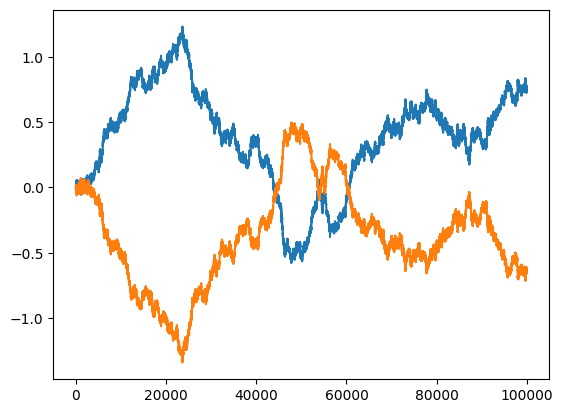

In [86]:
# Generation of Brownian motions (Cumulative sum of Gaussian increments)
for path in generate_correlated_brownians(rho=-0.99):
    plt.plot(path)

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Constant drift/Constant volatility</span>

In [66]:
# TODO

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Constant volatility</span>

In [87]:
class BlackScholesModel(EquityModel):
    """ Class representing the Black & Scholes model """
    
    MODEL_NAME = "BLACK-SCHOLES"
    
    def __init__(self, S0: float, r: RatesModel, sigma: float, rho: float) -> None:
        """
        Default constructor in order to verify the validity of the parameters, and store them
        """
        # Verification of parameters
        assert S0 > 0 and sigma > 0
        assert rho <= 1 and rho >= -1 # Boundaries for Brownian motions
        
        # Check if the rate model is a registered and valid model 
        if not issubclass(type(r), RatesModel): # type(r).__bases__[0] == RatesModel
            raise Exception("r must be a registered interest rates model\n(Available models: Vasicek, CIR, HW)")
                
        # Storing variables
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.rho = rho
        
    def __repr__(self) -> str:
        """
        Hard string representation
        """
        return f"Black-Scholes model {model.get_parameter_string(onLaTeX=False)}"
    
    def __str__(self) -> str:
        """
        Gentle string representation
        """
        return f"Black-Scholes model {model.get_parameter_string(onLaTeX=False)}"
  
    def get_parameter_string(self, onLaTeX: bool = True) -> str:
        """
        Function returning a user-friendly string displaying the model parameters values
        """
        if onLaTeX:
            return f"($S_0$ = {self.S0}, $\sigma$ = {self.sigma})"
        return f"(S0 = {self.S0}, sigma = {self.sigma})"
    
    def simulate_path(self, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate 1 path
        """
        if scheme == Scheme.EULER:
            return self.simulate_euler(**kwargs)
        return self.simulate_milstein(**kwargs)
    
    def simulate_paths(self, M: int = 3, scheme: Scheme = Scheme.EULER, **kwargs) -> dict:
        """
        Function wrapping the 2 available simulators to simulate several paths
        """
        assert M >= 1 and type(M) == int
        
        res = []
        for m in range(1, M + 1):
            if scheme == Scheme.EULER:
                sim = self.simulate_euler(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
            elif scheme == Scheme.MILSTEIN:
                sim = self.simulate_milstein(**kwargs)
                if m == 1:
                    res.append(sim["t"])
                res.append(sim["r"])
        return res
    
    def simulate_euler(self,
                       T: float = 1.0,
                       N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Black-Scholes model dynamics
        using the Euler-Maruyama method
        Returns a dictionary (hashmap) with the time and generated asset price columns
        """
        pass
        
    def simulate_milstein(self,
                          T: float = 1.0,
                          N: int = _MAX_STEPS) -> dict:
        """
        Function implementing a path simulator following Black-Scholes model dynamics
        using the Milstein method
        Returns a dictionary (hashmap) with the time and generated asset price columns
        """
        pass

In [89]:
S0 = 10
sigma = 1e-2
rho = 0.4
dB, dW = generate_correlated_gaussians(rho=rho)
r = VasicekModel(0.01875, 0.20, 0.01, 0.012)
model = BlackScholesModel(S0, r, sigma, rho)

-------------- Generation of Brownian Motions --------------
Simulated rho: -0.6174501055549789 	Given rho: 0.4
Absolute error: 1.017450105554979


In [989]:
model.MODEL_NAME

'BLACK-SCHOLES'

### Black-Scholes model $\diamond$ <span style="background:red; color:white; padding: 2px 6px">Time-varying drift/Time-varying volatility</span>

## Analysis

### Distribution of $S_T$

### Computation of derivatives price

## Miscellaneous

### Simulation of the joint distribution $\Big(\int_0^T r_u \mathrm{d}u, S_T\Big) $

### Model refinement $\longrightarrow$ Constant to time-varying parameters

#### <u>Interest rates dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \theta(t)$ instead of $\theta \in \mathbb{R}^+$</span>

$\longrightarrow$ Check [**Hull \& White** model](#Hull-&-White-(HW)-$\diamond$-Extended-Vasicek)

#### <u>Equity index dynamics</u> $\leadsto$ <span style="background:gray; color:white; padding: 2px 6px">$t \longmapsto \sigma(t)$ instead of $\sigma \in \mathbb{R}^+$</span>

---
**Amal BACHA - Dalia BARBI - Khalil BATTIKH - Lucas RODRIGUEZ - Naïm SOUNI**
